# LAPD 'homeless' crimes: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
# data exported from '00-lapd-crimes-processing.ipynb'
src = pd.read_feather('/Users/mhustiles/data/data/LA/crimes.feather')

NameError: name 'pd' is not defined

In [3]:
src.sort_values('date_reported', ascending=False).head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
1144887,2066356,201504590,2020-01-13,2019-12-29,0001,15,N Hollywood,1557,1,330,Burglary from vehicle,1300 0344,38,female,B,108,Parking lot,nan,None,IC,invest_cont,330,nan,nan,nan,10800 CAMARILLO ST,None,34.1577,-118.3659,2019,4,29,12,Sunday,December,black,00,01,pt_one_property
1071885,1939529,200304717,2020-01-13,2019-06-01,0001,3,Southwest,361,1,815,Sexual penetration w/foreign object,1258 1251 0522 0515 0558,11,female,B,502,"Multi-unit dwelling (apartment, duplex, etc)",400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,812,815,nan,nan,3900 GIBRALTAR AV,None,34.0161,-118.3547,2019,2,1,6,Saturday,June,black,00,01,pt_one_violent
1066728,1930572,201504589,2020-01-13,2019-12-28,1755,15,N Hollywood,1562,1,341,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",0394,27,female,W,501,Single family dwelling,nan,None,IC,invest_cont,341,nan,nan,nan,MILBANK,COLDWATER CANYON,34.1533,-118.4138,2019,4,28,12,Saturday,December,white,17,55,pt_one_property
1147453,2070821,201504613,2020-01-13,2019-12-29,2100,15,N Hollywood,1522,1,230,"Assault with deadly weapon, aggravated assault",1310 0416 0446 0431 1309,51,male,O,104,Driveway,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,230,nan,nan,nan,6700 COLDWATER CANYON AV,None,34.1936,-118.4166,2019,4,29,12,Sunday,December,other,21,00,pt_one_violent
1084683,1961582,201904550,2020-01-13,2019-11-24,0700,19,Mission,1988,1,330,Burglary from vehicle,0385,25,female,H,101,Street,nan,None,IC,invest_cont,330,nan,nan,nan,13700 BRANFORD ST,None,34.2281,-118.4308,2019,4,24,11,Sunday,November,hispanic,07,00,pt_one_property


In [1]:
src[(src['modus_operandi_code'].str.contains('1218', na=False))]

NameError: name 'src' is not defined

---

## Limit dataframe to serious crimes — the type reported to FBI

In [5]:
crimes = pd.DataFrame(src[src['part_type'] == '1'])

### Cases involving suspects or victimes defined by LAPD as 'homeless'

In [6]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])

In [7]:
mocodes = pd.read_csv('mo_codes.csv')
mocodes.head()

,mo_code,mo_code_description
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


In [8]:
# Chief Beck orders departmentwide focus on coding in 2016
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

,mo_code,mo_code_description
361,1218,Victim was Homeless/Transient
521,2004,Suspect is homeless/transient


### Limit homeless crime data to recent years to account for coding issues

In [9]:
homeless_dates = ['2018','2019']

### Various filters

In [10]:
#Homeless people codes
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) &\
                          (crimes['year'].isin(homeless_dates))]

In [11]:
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) &\
                           (crimes['year'].isin(homeless_dates))]

In [12]:
homeless_both = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) &\
                           (crimes['year'].isin(homeless_dates)) \
                       & (crimes['modus_operandi_code'].str.contains('1218', na=False))]

In [13]:
len(homeless_both)

2725

In [14]:
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('Criminal homicide', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

In [15]:
homeless_victims_women = homeless_victims[homeless_victims['victim_sex'] == 'female']

### How many cases do we have involving homeless people? 

In [16]:
len(homeless_victims_women)

2399

In [17]:
len(homeless_victims)

6735

In [18]:
homeless_victims['year'].value_counts()

2019    3747
2018    2988
Name: year, dtype: int64

In [19]:
homeless_victims['victim_sex'].value_counts('normalize')

male       0.641521
female     0.356252
unknown    0.002228
Name: victim_sex, dtype: float64

In [20]:
homeless_victims_year_count = homeless_victims.groupby(['year']).agg('size').reset_index(name='count')
homeless_victims_year_count.head()

,year,count
0,2018,2988
1,2019,3747


In [21]:
((homeless_victims_year_count['count'].loc[1] - homeless_victims_year_count['count'].loc[0]) /\
homeless_victims_year_count['count'].loc[0])*100

25.40160642570281

In [22]:
len(homeless_suspects)

10832

In [23]:
homeless_suspects_year_count = homeless_suspects.groupby(['year']).agg('size').reset_index(name='count')
homeless_suspects_year_count.head()

,year,count
0,2018,4911
1,2019,5921


In [24]:
((homeless_suspects_year_count['count'].loc[1] - homeless_suspects_year_count['count'].loc[0]) /\
homeless_suspects_year_count['count'].loc[0])*100

20.566076155569128

In [25]:
homeless_victims.columns

Index(['index', 'record_id', 'date_reported', 'date_occurred', 'time_occurred',
       'division', 'division_name', 'reporting_district', 'part_type',
       'crime_code', 'crime_code_description', 'modus_operandi_code',
       'victim_age', 'victim_sex', 'victim_descent', 'premises_code',
       'premises_description', 'weapon_code', 'weapon_description',
       'status_code', 'status_code_description', 'crm_cd_1', 'crm_cd_2',
       'crm_cd_3', 'crm_cd_4', 'address', 'cross_street', 'latitude',
       'longitude', 'year', 'quarter', 'day', 'month', 'weekday', 'monthname',
       'descent_description', 'hour', 'minute', 'part_category'],
      dtype='object')

---

In [26]:
homeless_victims.head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
915636,1668286,180412699,2018-07-24,2018-07-24,0930,4,Hollenbeck,464,1,761,Brandish weapon,0334 1218,31,male,B,109,Park/playground,218.0,Other cutting instrument,IC,invest_cont,761,nan,nan,nan,SAINT LOUIS,4TH ST,34.0423,-118.2155,2018,3,24,7,Tuesday,July,black,09,30,pt_one_violent
915674,1668350,180815439,2018-08-30,2018-08-30,1510,8,West LA,884,1,440,Theft plain - petty ($950 & under),1218 2004 0344 2032,41,male,H,102,Sidewalk,nan,None,IC,invest_cont,440,nan,nan,nan,11100 W PICO BL,None,34.0370,-118.4351,2018,3,30,8,Thursday,August,hispanic,15,10,pt_one_property
915689,1668373,180705615,2018-02-04,2018-02-04,2000,7,Wilshire,763,1,210,Robbery,0344 1218 2004 0416,24,female,B,101,Street,400.0,"Strong-arm (hands, fist, feet or bodily force)",AO,adult_other,210,nan,nan,nan,5500 AIRDROME ST,None,34.0456,-118.3676,2018,1,4,2,Sunday,February,black,20,00,pt_one_violent
915699,1668389,181918004,2018-09-24,2018-09-24,0030,19,Mission,1981,1,210,Robbery,1218 0334 0355 0429,43,male,W,101,Street,200.0,Knife with blade 6inches or less,IC,invest_cont,210,nan,nan,nan,SEPULVEDA BL,PARTHENIA ST,34.2283,-118.4677,2018,3,24,9,Monday,September,white,00,30,pt_one_violent
915706,1668401,181412414,2018-05-16,2018-05-16,0720,14,Pacific,1413,1,230,"Assault with deadly weapon, aggravated assault",1402 2004 1218,25,male,W,101,Street,217.0,Sword,AO,adult_other,230,998,nan,nan,SANTA CLARA,ABBOT KINNEY BL,33.9912,-118.4682,2018,2,16,5,Wednesday,May,white,07,20,pt_one_violent


---

### Group by cases involving homeless victims

In [27]:
homeless_victims_divisions = homeless_victims.groupby\
(['division_name']).agg('size').reset_index(name='total')

In [28]:
homeless_victims_divisions.head()

,division_name,total
0,77th Street,179
1,Central,2429
2,Devonshire,103
3,Foothill,112
4,Harbor,228


### Group by cases involving homeless suspects

In [29]:
homeless_suspects_divisions = homeless_suspects.groupby\
(['division_name']).agg('size').reset_index(name='total')

In [30]:
homeless_suspects_divisions.head()

,division_name,total
0,77th Street,253
1,Central,2526
2,Devonshire,243
3,Foothill,220
4,Harbor,356


---

### Homeless homicides

In [31]:
homeless_homicides.head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
915781,1668556,180600613,2018-01-23,2018-01-22,2300,6,Hollywood,647,1,110,Criminal homicide,1218 1402 0416 0449 1401 1409 2004,45,male,H,110,Freeway,308.0,Stick,AA,adult_arrest,110,998,nan,nan,VENTURA BL,SUNSET BL,34.0998,-118.3211,2018,1,22,1,Monday,January,hispanic,23,00,pt_one_violent
919839,1675527,180123968,2018-09-16,2018-09-16,0430,1,Central,152,1,110,Criminal homicide,0400 0416 1218 2004 0344,59,male,B,102,Sidewalk,304.0,Club/bat,AA,adult_arrest,110,nan,nan,nan,700 WILSHIRE BL,None,34.0487,-118.2571,2018,3,16,9,Sunday,September,black,04,30,pt_one_violent
921234,1677995,181100849,2018-11-11,2018-11-11,0335,11,Northeast,1123,1,110,Criminal homicide,1100 0430 1218 0395,40,male,W,501,Single family dwelling,104.0,Shotgun,AO,adult_other,110,nan,nan,nan,3100 GLENMANOR PL,None,34.1170,-118.2637,2018,4,11,11,Sunday,November,white,03,35,pt_one_violent
922486,1680242,180305553,2018-01-24,2018-01-24,1100,3,Southwest,399,1,110,Criminal homicide,1100 0430 0906 1218,42,male,B,152,Underpass/bridge*,106.0,Unknown firearm,IC,invest_cont,110,nan,nan,nan,42ND ST,FLOWER ST,34.0074,-118.2815,2018,1,24,1,Wednesday,January,black,11,00,pt_one_violent
922665,1680533,181113057,2018-07-06,2018-07-06,0950,11,Northeast,1181,1,110,Criminal homicide,0369 0446 0400 1218 2004 1402,50,male,H,108,Parking lot,400.0,"Strong-arm (hands, fist, feet or bodily force)",AA,adult_arrest,110,998,nan,nan,1400 GLENDALE BL,None,34.0808,-118.2655,2018,3,6,7,Friday,July,hispanic,09,50,pt_one_violent


In [32]:
homeless_homicides_years = homeless_homicides.groupby\
(['year','division_name', 'premises_description','weapon_description']).agg('size').reset_index(name='total')

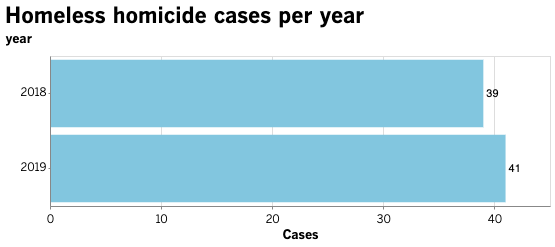

In [33]:
chart_homeless_homicides_years = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('year:N', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_homicides_years_text = chart_homeless_homicides_years.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)

(chart_homeless_homicides_years + chart_homeless_homicides_years_text).properties(height=150, width=500, title='Homeless homicide cases per year')

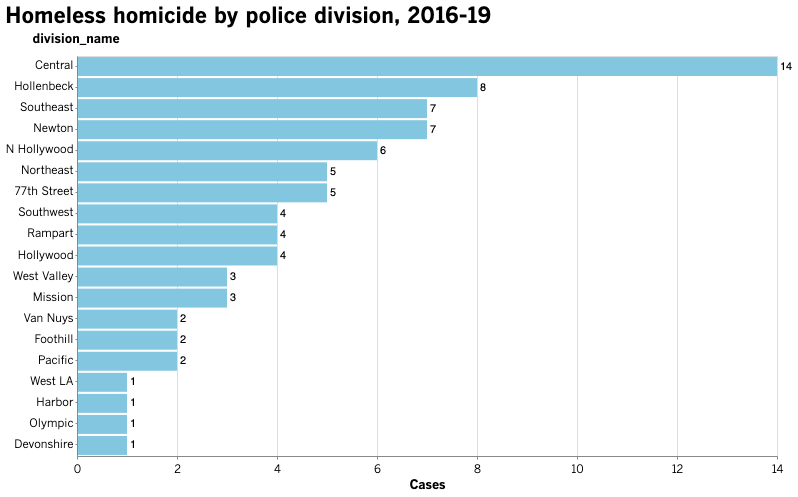

In [34]:
chart_homeless_divisions = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('division_name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_divisions_text = chart_homeless_divisions.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)


(chart_homeless_divisions + chart_homeless_divisions_text)\
.properties(height=400, width=700, title='Homeless homicide by police division, 2016-19')

In [35]:
# chart_homeless_weapon = alt.Chart(homeless_homicides_years).mark_bar().encode(
#     y=alt.Y('weapon_description:N',
#         sort=alt.EncodingSortField(
#             field="total",  # The field to use for the sort
#             op="sum",  # The operation to run on the field prior to sorting
#             order="descending"  # The order to sort in
#         ), axis=alt.Axis(format='', tickCount=5)),
#     x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
# )

# chart_homeless_weapon_text = chart_homeless_weapon.mark_text(
#     align='left',
#     baseline='middle',
#     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='sum(total):Q'
# )

# (chart_homeless_weapon + chart_homeless_weapon_text)\
#     .properties(height=400, width=700, title='Homeless homicide by weapon type, 2016-19')

In [36]:
# chart_homeless_location = alt.Chart(homeless_homicides_years).mark_bar().encode(
#     y=alt.Y('premises_description:N',
#         sort=alt.EncodingSortField(
#             field="total",  # The field to use for the sort
#             op="sum",  # The operation to run on the field prior to sorting
#             order="descending"  # The order to sort in
#         ), axis=alt.Axis(format='', tickCount=5)),
#     x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
# )

# chart_homeless_location_text = chart_homeless_location.mark_text(
#     align='left',
#     baseline='middle',
#     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='sum(total):Q'
# )

# (chart_homeless_location + chart_homeless_location_text)\
# .properties(height=400, width=700, title='Homeless homicide by location type, 2017-19')

---

## Homeless victims

In [37]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head()

,year,division_name,total
22,2019,Central,1453
1,2018,Central,976
34,2019,Rampart,237
13,2018,Rampart,223
30,2019,Newton,222


In [38]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head(10)

,year,division_name,total
22,2019,Central,1453
1,2018,Central,976
34,2019,Rampart,237
13,2018,Rampart,223
30,2019,Newton,222
9,2018,Newton,198
27,2019,Hollywood,192
33,2019,Pacific,187
6,2018,Hollywood,168
12,2018,Pacific,157


### Where do crimes involving homeless victims occur? 

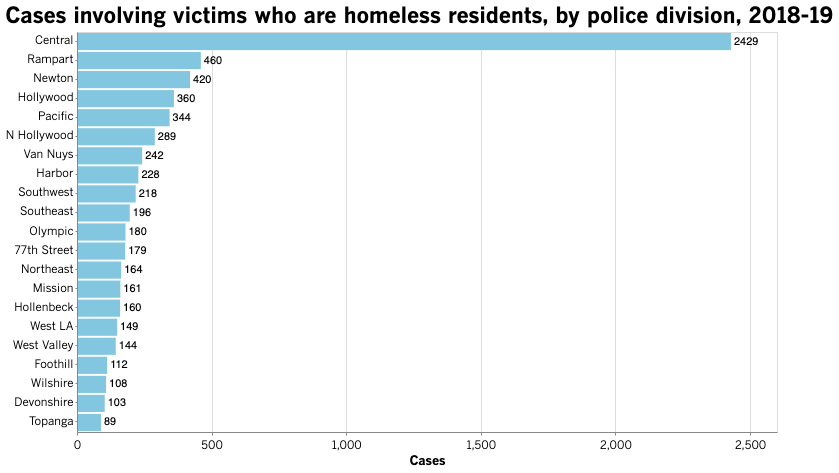

In [39]:
chart_homeless_victims = alt.Chart(homeless_victims_divisions).mark_bar().encode(
    y=alt.Y('division_name:N', title='',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_victims_text = chart_homeless_victims.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)


(chart_homeless_victims + chart_homeless_victims_text)\
.properties(height=400, width=700, title='Cases involving victims who are homeless \
residents, by police division, 2018-19')

In [40]:
homeless_victims['division_name'].value_counts('normalize').round(2)*100

Central        36.0
Rampart         7.0
Newton          6.0
Hollywood       5.0
Pacific         5.0
N Hollywood     4.0
Van Nuys        4.0
Harbor          3.0
Southwest       3.0
Southeast       3.0
Olympic         3.0
77th Street     3.0
Northeast       2.0
Mission         2.0
Hollenbeck      2.0
West LA         2.0
West Valley     2.0
Foothill        2.0
Wilshire        2.0
Devonshire      2.0
Topanga         1.0
Name: division_name, dtype: float64

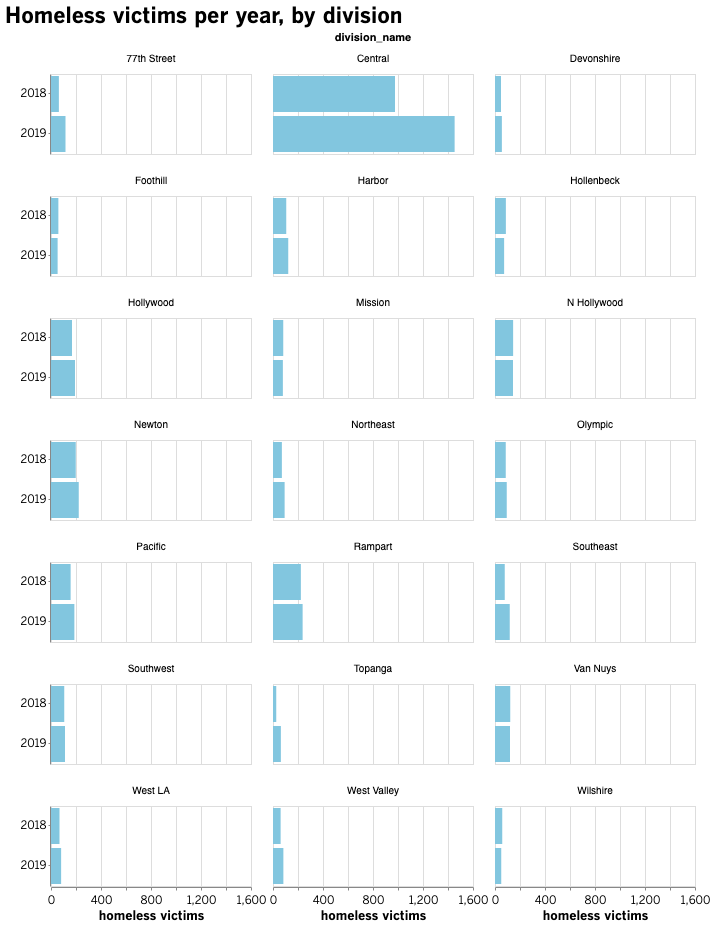

In [41]:
alt.Chart(homeless_year_victim).mark_bar().encode(
    y=alt.Y('year:N', title='', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("mean(total):Q", title="homeless victims", axis=alt.Axis(format='', tickCount=10)),
    facet='division_name:N'
).properties(height=80, width=200, columns=3, title='Homeless victims per year, by division')

### What types of crimes are most common for homeless victims?

In [42]:
homeless_cases_victim = homeless_victims.groupby(['crime_code_description','victim_sex', 'year'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_cases_victim_top = homeless_cases_victim[homeless_cases_victim['total'] > 25]

In [43]:
homeless_cases_victim[homeless_cases_victim['victim_sex'] == 'male']

,crime_code_description,victim_sex,year,total
8,"Assault with deadly weapon, aggravated assault",male,2019,1033
7,"Assault with deadly weapon, aggravated assault",male,2018,828
65,Robbery,male,2019,426
64,Robbery,male,2018,386
96,Theft plain - petty ($950 & under),male,2019,386
95,Theft plain - petty ($950 & under),male,2018,269
24,Brandish weapon,male,2019,120
42,Intimate partner - aggravated assault,male,2019,86
23,Brandish weapon,male,2018,84
106,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",male,2019,65


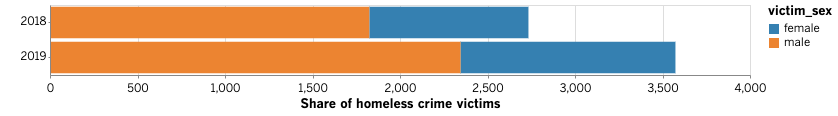

In [44]:
base_gender = alt.Chart(homeless_cases_victim_top).mark_bar().encode(
    x=alt.X('sum(total)', title='Share of homeless crime victims', axis=alt.Axis(tickCount=6)),
    y=alt.Y('year:N',title='',
            sort=alt.EncodingSortField(
            field="year:N",  # The field to use for the sort
            op="count",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in)
            )),
    color='victim_sex:N'
)

base_gender_text = base_gender.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(text=alt.Text('sum(total)', format=','), 
    color=alt.condition(
        alt.datum.year == '2018',
        alt.value('white'),
        alt.value('white')
    )
)


(base_gender + base_gender_text).properties(height=70,width=700)

### Homeless victims in central

In [45]:
homeless_victims_central = homeless_victims[homeless_victims['division_name'] == 'Central']

In [46]:
homeless_cases_victim_central = homeless_victims_central.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [47]:
homeless_cases_victim_central.head()

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",665
25,Theft plain - petty ($950 & under),597
16,Robbery,390
5,Brandish weapon,125
10,Intimate partner - aggravated assault,122


---

In [48]:
homeless_cases_suspect = homeless_suspects.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [49]:
homeless_cases_suspect.head(10)

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",2920
22,Robbery,1790
25,Shoplifting - petty theft ($950 & under),1513
6,Brandish weapon,805
7,Burglary,762
33,Theft plain - petty ($950 & under),735
16,Intimate partner - aggravated assault,516
3,Attempted robbery,335
35,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",202
8,Burglary from vehicle,201


--- 

### What are the population breakdowns for men and women?

In [50]:
homeless_female_pop_share19 = 30.1
homeless_male_pop_share19 = 67.3
homeless_male_pop19 = 24360
homeless_female_pop19 = 10845

homeless_female_pop_share19 = 31
homeless_male_pop_share19 = 67
homeless_male_pop18 = 20907
homeless_female_pop18 = 9577

city_female_pop_share = 50.5
city_male_pop_share = 45.5
city_female_pop = 2015180
city_male_pop = 1815657

--- 

### Import homeless population by LA Times neighborhood

In [51]:
homeless_pop = \
pd.read_csv('/Users/mhustiles/data/github/notebooks/homeless-restrictions-raw/output\
/homeless-apportioned-totals-by-neighborhood.csv')

In [52]:
homeless_pop = homeless_pop[homeless_pop['totpeople'] > 1]

### Relate homeless victim/suspect incident data to LA neighborhoods, not just police geography

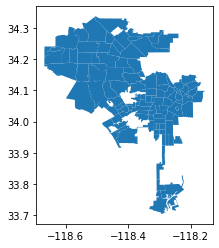

In [53]:
# Read Los Angeles Times neighborhoods
hoods = gpd.read_file('input/custom-la-hoods-skid-row.geojson')
hoods.plot()

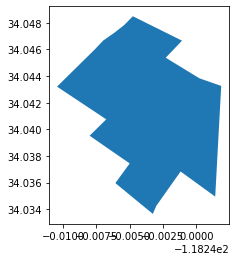

In [54]:
skidrow = hoods[hoods['name'] == 'Skid Row']
skidrow.plot()

### Convert homeless victims dataframe to geodataframe, set CRS, join with 'hoods 

In [55]:
homeless_victims_gdf = gpd.GeoDataFrame(homeless_victims, \
    geometry=gpd.points_from_xy(homeless_victims.longitude, homeless_victims.latitude))
homeless_victims_gdf.crs = ({'init':'epsg:4326'})
homeless_victims_hoods = gpd.sjoin(homeless_victims_gdf, hoods, op = 'within')

### Convert homeless suspects dataframe to geodataframe, set CRS, join with 'hoods 

In [56]:
homeless_suspects_gdf = gpd.GeoDataFrame(homeless_suspects, \
    geometry=gpd.points_from_xy(homeless_suspects.longitude, homeless_suspects.latitude))
homeless_suspects_gdf.crs = ({'init':'epsg:4326'})
homeless_suspects_hoods = gpd.sjoin(homeless_suspects_gdf, hoods, op = 'within')

### Group by hood name

In [57]:
homeless_victims_hoods_grouped = homeless_victims_hoods.groupby(['name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [58]:
homeless_suspects_hoods_grouped = homeless_suspects_hoods.groupby(['name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [59]:
homeless_suspects_hoods_grouped.head(10)

,name,total
22,Downtown,1724
85,Skid Row,935
46,Hollywood,560
97,Van Nuys,438
108,Westlake,436
98,Venice,414
66,North Hollywood,334
51,Koreatown,239
24,East Hollywood,214
8,Boyle Heights,185


In [60]:
homeless_victims_hoods_grouped.head(10)

,name,total
82,Skid Row,1478
19,Downtown,1098
43,Hollywood,310
105,Westlake,300
95,Venice,237
94,Van Nuys,222
63,North Hollywood,157
48,Koreatown,142
21,East Hollywood,118
42,Historic South-Central,107


### Calculate crime rate among homeless victims

In [61]:
homeless_victims_hoods_merged = pd.merge(homeless_victims_hoods_grouped, homeless_pop, on='name')

In [62]:
homeless_victims_hoods_merged.sort_values(by='totpeople', ascending=False)

,name,total,unsheltered,unshelteredoutside,totpeople
0,Skid Row,1478,1560.699515,1511.234336,3483.296138
1,Downtown,1098,2477.656050,2298.862691,2993.002167
3,Westlake,300,1239.655588,921.219987,1755.307232
2,Hollywood,310,1191.539096,634.890246,1454.445295
9,Historic South-Central,107,944.710611,673.731808,1193.057813
17,Sun Valley,65,740.138565,245.318142,1152.144565
4,Venice,237,1091.534800,567.493195,1101.539811
10,Boyle Heights,107,869.935630,512.306282,1071.937630
5,Van Nuys,222,675.235038,327.020823,755.125837
16,Vermont Square,66,319.691371,184.630879,665.101111


In [63]:
homeless_victims_hoods_merged['rate'] = \
(homeless_victims_hoods_merged['total'] / (homeless_victims_hoods_merged['totpeople']/1000)).round(1)

In [64]:
homeless_victims_hoods_merged.sort_values(by='rate', ascending=False)

,name,total,unsheltered,unshelteredoutside,totpeople,rate
83,Toluca Lake,9,12.367069,9.539124,12.367069,727.7
108,Larchmont,2,3.229615,3.129461,3.229615,619.3
72,Lake Balboa,14,23.329680,6.488715,24.167177,579.3
99,Hollywood Hills West,3,6.521895,5.432202,6.521895,460.0
0,Skid Row,1478,1560.699515,1511.234336,3483.296138,424.3
37,Northridge,33,84.921058,23.224370,85.088915,387.8
33,Chatsworth,36,94.794345,22.518636,94.794345,379.8
24,Studio City,47,124.080220,99.805643,124.080220,378.8
53,Tarzana,22,58.463844,22.162998,58.463844,376.3
19,North Hills,56,124.911940,72.748118,149.904106,373.6


### Calculate breaks for crime rate

In [65]:
breaks_rate \
= jenkspy.jenks_breaks(homeless_victims_hoods_merged.rate, nb_class=7)

In [66]:
breaks_rate

[21.1, 70.7, 121.3, 172.5, 247.8, 343.0, 460.0, 727.7]

In [67]:
def get_group_rate(value):
    for i, b in enumerate(breaks_rate):
        if value <= breaks_rate[i+1]:
            return i

In [68]:
homeless_victims_hoods_merged['rate_score'] = homeless_victims_hoods_merged.rate.apply(get_group_rate)

### Calculate breaks for total crimes

In [69]:
breaks_crimes \
= jenkspy.jenks_breaks(homeless_victims_hoods_merged.total, nb_class=7)

In [70]:
breaks_crimes

[1.0, 16.0, 41.0, 81.0, 157.0, 310.0, 1098.0, 1478.0]

In [71]:
def get_group_crimes(value):
    for i, b in enumerate(breaks_crimes):
        if value <= breaks_crimes[i+1]:
            return i

In [72]:
homeless_victims_hoods_merged['crimes_score'] = homeless_victims_hoods_merged.total.apply(get_group_crimes)

In [73]:
homeless_victims_hoods_merged.sort_values(by='crimes_score', ascending=False).head()

,name,total,unsheltered,unshelteredoutside,totpeople,rate,rate_score,crimes_score
0,Skid Row,1478,1560.699515,1511.234336,3483.296138,424.3,5,6
1,Downtown,1098,2477.656050,2298.862691,2993.002167,366.9,5,5
2,Hollywood,310,1191.539096,634.890246,1454.445295,213.1,3,4
3,Westlake,300,1239.655588,921.219987,1755.307232,170.9,2,4
4,Venice,237,1091.534800,567.493195,1101.539811,215.2,3,4


### Merge homeless victim rate by 'hoods back to the 'hoods geodataframe

In [74]:
homeless_victims_maps = hoods.merge(homeless_victims_hoods_merged, on='name', how='left')

In [75]:
homeless_victims_maps.to_file('output/homeless_victims_maps.geojson', driver='GeoJSON')

In [76]:
geojson = json.loads(homeless_victims_maps.to_json())

In [77]:
features = alt.Data(values=geojson['features'])

In [78]:
base = alt.Chart(features).mark_geoshape(
    stroke='white',
    fill='#e6e6e6',
    strokeWidth=0.1
).encode().properties(
    width=400,
    height=600
)

In [79]:
geoshape = alt.Chart(features).mark_geoshape(
    fill='#e6e6e6',
    stroke='white'
)

In [80]:
rate = geoshape.encode(
    color=alt.Color(
        "properties.rate_score:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
            tooltip=['properties.name:N', 'properties.rate:N'],
)

crimesall = geoshape.encode(
    color=alt.Color(
        "properties.crimes_score:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
            tooltip=['properties.name:N', 'properties.rate:N'],
)

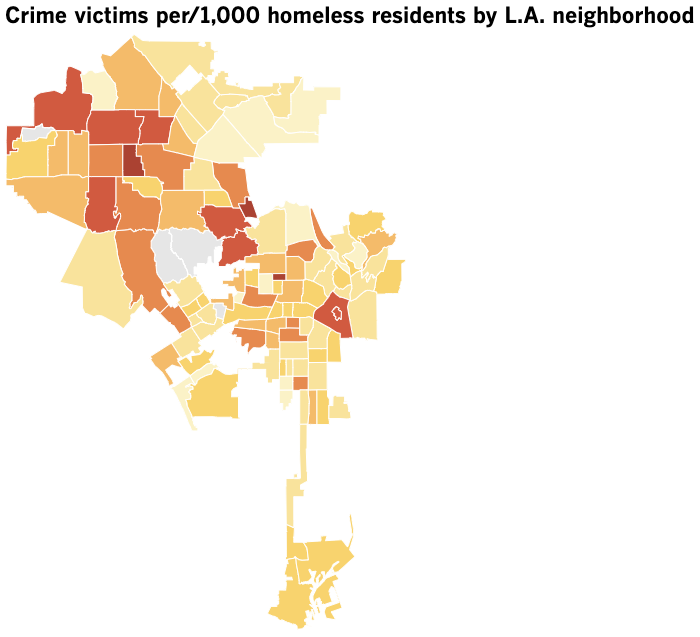

In [81]:
(base + rate).properties(title="Crime victims per/1,000 homeless residents by L.A. neighborhood").configure_view(
    strokeWidth=0
)

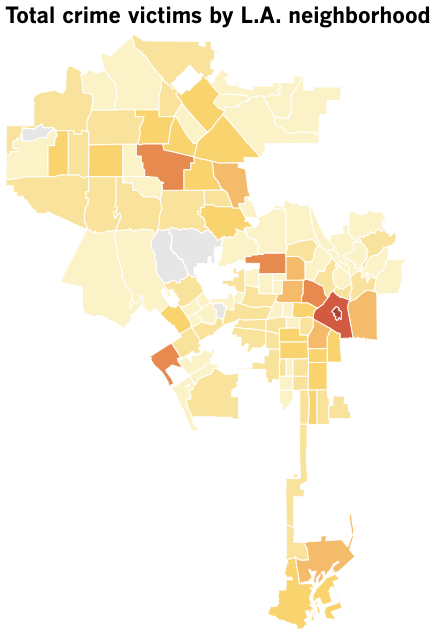

In [82]:
(base + crimesall).properties(title="Total crime victims by L.A. neighborhood").configure_view(
    strokeWidth=0
)

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [83]:
all_crimes_grouped = crimes.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [84]:
all_crimes_grouped.head(10)

,crime_code_description,total
9,Burglary from vehicle,162050
54,Vehicle - stolen,159722
42,Theft plain - petty ($950 & under),149561
8,Burglary,147409
2,"Assault with deadly weapon, aggravated assault",92632
39,Theft from motor vehicle - petty ($950 & under),88368
29,Robbery,83813
47,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",74299
32,Shoplifting - petty theft ($950 & under),48380
38,Theft from motor vehicle - grand ($400 and over),31605


### Which crimes are most common for homeless victims?

In [85]:
homeless_crimes_grouped = homeless_victims.groupby(['crime_code_description', 'victim_sex'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [86]:
homeless_cases_victim.head(10)

,crime_code_description,victim_sex,year,total
8,"Assault with deadly weapon, aggravated assault",male,2019,1033
7,"Assault with deadly weapon, aggravated assault",male,2018,828
65,Robbery,male,2019,426
64,Robbery,male,2018,386
96,Theft plain - petty ($950 & under),male,2019,386
94,Theft plain - petty ($950 & under),female,2019,286
6,"Assault with deadly weapon, aggravated assault",female,2019,276
95,Theft plain - petty ($950 & under),male,2018,269
5,"Assault with deadly weapon, aggravated assault",female,2018,256
40,Intimate partner - aggravated assault,female,2019,194


### Places where crimes against homeless residents occur?

In [87]:
# homeless victims
homeless_places = homeless_victims.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

# all crimes
places = crimes.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [88]:
homeless_places['share'] = ((homeless_places['total'] / homeless_places.total.sum())*100).round(2)

In [89]:
homeless_places.head()

,premises_description,total,share
118,Sidewalk,2059,30.57
126,Street,1791,26.59
91,"Multi-unit dwelling (apartment, duplex, etc)",387,5.75
103,Parking lot,386,5.73
2,Alley,232,3.44


In [90]:
places['share'] = ((places['total'] / places.total.sum())*100).round(2)

In [91]:
places.head()

,premises_description,total,share
273,Street,358571,30.65
262,Single family dwelling,146704,12.54
229,Parking lot,115353,9.86
207,"Multi-unit dwelling (apartment, duplex, etc)",85681,7.32
261,Sidewalk,61525,5.26


### Where are homeless victims cases occuring in LAPD's divisions? 

In [92]:
homeless_divisions = homeless_victims.groupby(['division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [93]:
homeless_divisions.head(10)

,division_name,total
1,Central,2429
13,Rampart,460
9,Newton,420
6,Hollywood,360
12,Pacific,344
8,N Hollywood,289
17,Van Nuys,242
4,Harbor,228
15,Southwest,218
14,Southeast,196


### Which days of the week?

In [94]:
# homeless victims
homeless_weekdays = homeless_victims.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
# all crimes
weekdays = crimes.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

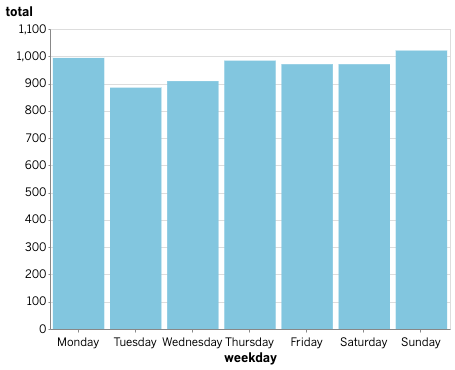

In [95]:
homeless_weekdays.head(7)
alt.Chart(homeless_weekdays).mark_bar().encode(
    x=alt.X('weekday:N', 
sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y='total:Q'
).properties(width=400, height=300)

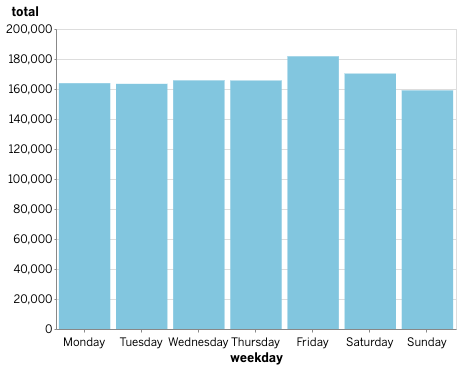

In [96]:
weekdays.head(7)
alt.Chart(weekdays).mark_bar().encode(
    x=alt.X('weekday:N', 
sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y='total:Q'
).properties(width=400, height=300)

---

## What's the crude crime rate among all Angelenos vs. homeless Angelenos? 

[Computational formulas](https://oag.ca.gov/sites/all/files/agweb/pdfs/cjsc/prof10/formulas.pdf) from California Office of Attorney General: A crime rate is calculated by dividing the number of reported crimes by the total population; the result is multiplied by 100,000. For example, in 2010 there were 58,100 robberies in California and the population was 38,826,898. This equals a robbery crime rate of 149.6 per 100,000 general population

In [97]:
crimes2019 = len(crimes[crimes['year'] == '2019'])

In [98]:
crimes2019

123143

In [99]:
homelessvictims2019 = len(homeless_victims[homeless_victims['year'] == '2019'])

In [100]:
homelessvictims2019

3747

### Part I crimes per 1,000 Angelenos in 2019

In [101]:
(crimes2019 / 3990456)*1000

30.859380481829643

### Part I crimes per 1,000 homeless Angelenos in 2019

In [102]:
(homelessvictims2019 / (homeless_female_pop19+homeless_male_pop19))*1000

106.43374520664678

### Robberies per 1,000 Angelenos in 2019

In [103]:
len(crimes[(crimes['crime_code_description'] == 'Robbery') &\
            (crimes['year'] == '2019')]) / 3990456 * 1000

2.109282748638251

### Robberies per 1,000 homeless Angelenos in 2019

In [104]:
len(homeless_victims[(homeless_victims['crime_code_description'] == 'Robbery') &\
            (homeless_victims['year'] == '2019')]) / (homeless_female_pop19+homeless_male_pop19) * 1000

16.332907257491833

---